# Experiment 017

In this experiment, we will try to improve the board accuracy of the generator. Since the generator is based on a model architecture that worked very well in the non-GAN setting, we will keep the generator fixed for now and try improving the discriminator architecture. In particular, we should make it better at dealing with block spawns and with fine details.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it), default=-1)

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)

        def transform(board):
            board = torch.tensor(board, dtype=torch.long)
            board = F.one_hot(board, 2) # One-hot encode the cell types
            board = board.type(torch.float) # Convert to floating-point
            board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
            return board

        x = transform(boards[-2]) # Ignore all boards except the last two
        y = transform(boards[-1])
        return x, y
        

In [3]:
train_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "train"))
test_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "test"))
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 2, 22, 10]) torch.float32
torch.Size([4, 2, 22, 10]) torch.float32


In [4]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [5]:
class TetrisModel(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of float32 of shape (batch_size, channels, height, width). channels = 2 is the one-hot encoding of cell types, with
           0 for empty cells and 1 for filled cells. height = 22 and width = 10 are the dimensions of the game board. The entries
           should be 0 for empty cells and 1 for filled cells.
        z: Tensor of float32 of shape (batch_size, 4). The entries should be random numbers sampled from a uniform distribution.
    
    Returns: Tensor of float32 of shape (batch_size, height, width), logits for the new cells. Probabilities close to 0 (negative logits)
             correspond to empty cells, and probabilities close to 1 (positive logits) correspond to filled cells.
    """

    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(6, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x, z):
        batch_size, channels, height, width = x.shape
        
        z = z[:, :, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        y = self.head(x)
        return y

In [6]:
class TetrisDiscriminator(nn.Module):
    """A discriminator for the cell state predictions. Assesses the output of the generator.

    Inputs:
        x: Tensor of float32 of shape (batch_size, channels, height, width). channels = 2 is the one-hot encoding of cell types, with
           0 for empty cells and 1 for filled cells. height = 22 and width = 10 are the dimensions of the game board. The entries
           should be 0 for empty cells and 1 for filled cells.
        y: Tensor of float32 of shape (batch_size, channels, height, width), as with x. This should be either the output of the
           generator (with exp applied) or the one-hot encoding of the ground truth of the next cell states.
    
    Returns: Tensor of float32 of shape (batch_size, 1), decisions on whether the data are real or fake. Probabilities close to 0 (negative logits)
             correspond to fake data, and probabilities close to 1 (positive logits) correspond to real data.
    """

    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
                nn.Conv2d(4, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(16, 16, 3, padding=1, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(160, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Flatten(start_dim=0)
            )
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        logits = self.body(x)
        return logits

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def check_disc(disc):
    gen = TetrisModel().to(device)

    with torch.no_grad():
        X, y = next(iter(train_dataloader))
        z = torch.rand(batch_size, 4)
        y_gen = gen(X, z)
        pred_on_real = F.sigmoid(disc(X, y)[0])
        pred_on_fake = F.sigmoid(disc(X, y_gen)[0])
        print(f"Number of discriminator parameters: {count_parameters(disc)}")
        print(f"Predicted label for real data: {pred_on_real}")
        print(f"Predicted label for fake data: {pred_on_fake}")

In [8]:
import itertools

def find_interesting_examples(dataset, num=4):
    num_spawns = num // 2
    num_normal = num - num_spawns
    
    def inner():
        num_spawns_left = num_spawns
        num_normal_left = num_normal

        for x, y in dataset:
            # Check for block spawn
            if (x.argmax(0)[0] == 0).all() & (y.argmax(0)[0] == 1).any():
                if num_spawns_left > 0:
                    num_spawns_left -= 1
                    yield x, y
                else:
                    continue
            # Yield general examples
            if num_normal_left > 0:
                num_normal_left -= 1
                yield x, y
            else:
                continue
            
    return list(itertools.islice(inner(), num))

In [9]:
def render_prediction(x, pred, y):
    """Renders an example and prediction into a single-image array.
    
    Inputs:
        x: Tensor of shape (height, width), the model input.
        pred: Tensor of shape (height, width), the model prediction.
        y: Tensor of shape (height, width), the target.
    """
    assert len(x.shape) == 2, f"Expected tensors of shape (width, height) but got {x.shape}"
    assert x.shape == pred.shape, f"Shapes do not match: {x.shape} != {pred.shape}"
    assert x.shape == y.shape, f"Shapes do not match: {x.shape} != {y.shape}"
    height, width = x.shape
    with torch.no_grad():
        separator = torch.ones(height, 1, dtype=x.dtype)
        return torch.cat((x, separator, pred, separator, y), dim=-1)

In [10]:
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc):
    gen.train()
    disc.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        ##################################################################
        # (1) Update discriminator: minimize -log(D(x)) - log(1 - D(G(z)))
        ##################################################################
        disc.zero_grad()

        ## Train with all-real batch
        # Format batch
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through discriminator
        output = torch.flatten(disc(X, y))
        # Calculate loss on all-real batch
        err_disc_real = loss_fn(output, real_labels)
        # Calculate gradients for discriminator in backward pass
        err_disc_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.rand(batch_size, 4, device=device)
        # Generate fake image batch with generator
        y_fake = gen(X, z)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with discriminator
        output = torch.flatten(disc(X, y_fake.detach()))
        # Calculate discriminator's loss on the all-fake batch
        err_disc_fake = loss_fn(output, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()

        ## Update discriminator weights
        # Compute error of discriminator as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update discriminator
        optimizer_disc.step()

        ##############################################
        # (2) Update generator: minimize -log(D(G(z)))
        ##############################################
        gen.zero_grad()
        # Since we just updated the discriminator, perform another forward pass of the all-fake batch through it
        output = torch.flatten(disc(X, y_fake))
        # Calculate the generator's loss based on this output
        # We use real labels because the generator wants to fool the discriminator
        err_gen = loss_fn(output, real_labels)
        # Calculate gradients for generator
        err_gen.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if batch % 20 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] D loss: {err_disc.item():.4f}, G loss: {err_gen.item():.4f}")


def test_loop(split_name, dataloader, gen, disc, loss_fn, tb_writer, epoch, examples):
    gen.eval()
    disc.eval()

    loss_disc = 0.0
    loss_gen = 0.0
    disc_accuracy = 0.0
    cell_accuracy = 0.0
    board_accuracy = 0.0
    spawn_recall = 0.0
    num_spawns = 0.0
    spawn_precision = 0.0
    num_predicted_spawns = 0.0

    num_batches = len(dataloader)
    with torch.no_grad():        
        for X, y in dataloader:
            batch_size = X.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

            output_real = disc(X, y)
            loss_disc += loss_fn(output_real, real_labels).item()

            z = torch.rand(batch_size, 4, device=device)
            y_fake = gen(X, z)
            output_fake = disc(X, y_fake)
            
            loss_disc += loss_fn(output_fake, fake_labels).item()
            loss_gen += loss_fn(output_fake, real_labels).item()

            pred_real = (output_real > 0.0)
            pred_fake = (output_fake > 0.0)
            disc_accuracy += pred_real.type(torch.float).mean().item()
            disc_accuracy += (~pred_fake).type(torch.float).mean().item()

            classes_X = torch.argmax(X, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            cell_accuracy += (classes_y_fake == classes_y).type(torch.float).mean().item()
            board_accuracy += (classes_y_fake == classes_y).all(-1).all(-1).type(torch.float).mean().item()

            actual_spawns = (classes_X[:, 0, :] == 0).all(-1) & (classes_y[:, 0, :] == 1).any(-1)
            predicted_spawns = (classes_y_fake[:, 0, :] == 1).any(-1)
            num_true_positives = (actual_spawns & predicted_spawns).type(torch.float).sum().item()
            spawn_recall += num_true_positives
            num_spawns += actual_spawns.type(torch.float).sum().item()
            spawn_precision += num_true_positives
            num_predicted_spawns += predicted_spawns.type(torch.float).sum().item()

    loss_disc /= num_batches
    loss_gen /= num_batches
    cell_accuracy /= num_batches
    board_accuracy /= num_batches
    spawn_recall /= num_spawns
    spawn_precision = np.nan if (num_predicted_spawns == 0.0) else (spawn_precision / num_predicted_spawns)
    disc_accuracy /= (2.0 * num_batches)

    print(f"{split_name} error: \n D loss: {loss_disc:>8f}, G loss: {loss_gen:>8f}, D accuracy: {(100*disc_accuracy):>0.1f}%, cell accuracy: {(100*cell_accuracy):>0.1f}%, board accuracy: {(100*board_accuracy):>0.1f}% \n")

    tb_writer.add_scalar(f"Discriminator loss/{split_name}", loss_disc, epoch)
    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Discriminator accuracy/{split_name}", disc_accuracy, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy, epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy, epoch)
    tb_writer.add_scalar(f"Spawn recall/{split_name}", spawn_recall, epoch)

    with torch.no_grad():
        for i, (X, y) in enumerate(examples):
            X, y = X.unsqueeze(0), y.unsqueeze(0)
            z = torch.rand(1, 4, device=device)
            y_fake = gen(X, z)
            X, y, y_fake = X.squeeze(0), y.squeeze(0), y_fake.squeeze(0)
            X, y, y_fake = X.argmax(0), y.argmax(0), y_fake.argmax(0)
            img = render_prediction(X, y_fake, y)
            tb_writer.add_image(f"Predictions/{split_name}/{i}", img, epoch, dataformats="HW")


In [18]:
def train(run_name="", disc_cls=TetrisDiscriminator):
    learning_rate = 1e-2
    epochs = 50

    gen = TetrisModel().to(device)
    disc = disc_cls().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer_gen = torch.optim.SGD(gen.parameters(), lr=learning_rate)
    optimizer_disc = torch.optim.SGD(disc.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_017")
    log_subdir = os.path.join(log_dir, run_name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    train_examples = find_interesting_examples(train_dataset)
    test_examples = find_interesting_examples(test_dataset)

    for epoch in range(epochs):
        print(f"Epoch {epoch}\n-------------------------------")
        train_loop(train_dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc)
        test_loop("train", train_dataloader, gen, disc, loss_fn, tb_writer, epoch, train_examples)
        test_loop("test", test_dataloader, gen, disc, loss_fn, tb_writer, epoch, test_examples)
        for name, weight in gen.named_parameters():
            tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
            tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
        for name, weight in disc.named_parameters():
            tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
            tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)

    tb_writer.close()
    print("Done!")

In [19]:
class DiscWithMoreLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
                nn.Conv2d(4, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(16, 16, 3, padding=1, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(160, 16),
                nn.ReLU(),
                nn.Linear(16, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Flatten(start_dim=0)
            )
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        logits = self.body(x)
        return logits


check_disc(DiscWithMoreLinear().to(device))

Number of discriminator parameters: 5793
Predicted label for real data: 0.4673059284687042
Predicted label for fake data: 0.46102985739707947


In [20]:
class WiderDisc(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
                nn.Conv2d(4, 24, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(24, 24, 3, padding=1, bias=False),
                nn.BatchNorm2d(24),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(240, 20),
                nn.ReLU(),
                nn.Linear(20, 1),
                nn.Flatten(start_dim=0)
            )
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        logits = self.body(x)
        return logits


check_disc(WiderDisc().to(device))

Number of discriminator parameters: 10961
Predicted label for real data: 0.41659843921661377
Predicted label for fake data: 0.41942277550697327


In [21]:
class DiscWithNoUnevenMaxPools(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
                nn.Conv2d(4, 16, 3, padding=1), # (batch_size, 16, 22, 10)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), # (batch_size, 16, 11, 5)
                nn.Conv2d(16, 16, 3, bias=False), # (batch_size, 16, 9, 3)
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, bias=False), # (batch_size, 16, 7, 1)
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(112, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Flatten(start_dim=0)
            )
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        logits = self.body(x)
        return logits


check_disc(DiscWithNoUnevenMaxPools().to(device))

Number of discriminator parameters: 7089
Predicted label for real data: 0.5074602961540222
Predicted label for fake data: 0.5116638541221619


In [22]:
class DiscWithStridedConvs(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
                nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=2, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(160, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Flatten(start_dim=0)
            )
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        logits = self.body(x)
        return logits


check_disc(DiscWithStridedConvs().to(device))

Number of discriminator parameters: 5521
Predicted label for real data: 0.5421004295349121
Predicted label for fake data: 0.5194949507713318


In [23]:
for i in range(2):
    for cls in [TetrisDiscriminator, DiscWithMoreLinear, WiderDisc, DiscWithNoUnevenMaxPools, DiscWithStridedConvs]:
        train(run_name=cls.__name__, disc_cls=cls)

Epoch 0
-------------------------------
[4/1762] D loss: 1.3850, G loss: 0.8843
[84/1762] D loss: 1.0081, G loss: 1.1623
[164/1762] D loss: 1.1196, G loss: 0.4879
[244/1762] D loss: 1.1974, G loss: 0.3559
[324/1762] D loss: 1.0870, G loss: 1.2813
[404/1762] D loss: 1.0741, G loss: 1.6333
[484/1762] D loss: 1.2479, G loss: 0.3509
[564/1762] D loss: 1.2631, G loss: 3.2276
[644/1762] D loss: 1.4808, G loss: 0.7716
[724/1762] D loss: 0.8095, G loss: 0.9920
[804/1762] D loss: 0.9246, G loss: 0.6251
[884/1762] D loss: 1.3909, G loss: 0.9660
[964/1762] D loss: 1.2716, G loss: 0.6807
[1044/1762] D loss: 1.1564, G loss: 0.2983
[1124/1762] D loss: 1.6253, G loss: 0.3096
[1204/1762] D loss: 1.3028, G loss: 0.6137
[1284/1762] D loss: 1.5668, G loss: 1.2429
[1364/1762] D loss: 1.3711, G loss: 0.4331
[1444/1762] D loss: 1.2696, G loss: 1.1483
[1524/1762] D loss: 1.4281, G loss: 0.5287
[1604/1762] D loss: 1.3756, G loss: 0.5091
[1684/1762] D loss: 1.1031, G loss: 0.8073
[1762/1762] D loss: 1.3796, G 

None of these architectures show an improvement from the original. Let's try some more.

In [29]:
class DiagnosticModule(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x


class DiscWithOnlyStride1(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
                nn.Conv2d(4, 16, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, padding=1, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, (3, 1), bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, (3, 1), bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, (3, 1), bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 16, (3, 1), bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(192, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Flatten(start_dim=0)
            )
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        logits = self.body(x)
        return logits


check_disc(DiscWithOnlyStride1().to(device))

Number of discriminator parameters: 18577
Predicted label for real data: 0.47213485836982727
Predicted label for fake data: 0.4246426224708557


In [35]:
class DiscLocalGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(4, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Flatten(start_dim=0)
        )

    def forward(self, x, y):
        batch_size, channels, height, width = x.shape
        
        x = torch.cat((x, y), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        y = self.head(x)
        return y


check_disc(DiscLocalGlobal().to(device))

Number of discriminator parameters: 16959
Predicted label for real data: 0.6477737426757812
Predicted label for fake data: 0.537103533744812


In [36]:
for cls in [DiscWithOnlyStride1, DiscLocalGlobal]:
    train(run_name=cls.__name__, disc_cls=cls)

Epoch 0
-------------------------------
[4/1762] D loss: 1.4203, G loss: 0.9099
[84/1762] D loss: 0.8477, G loss: 1.1711
[164/1762] D loss: 0.4096, G loss: 2.1617
[244/1762] D loss: 1.0265, G loss: 1.8500
[324/1762] D loss: 0.3854, G loss: 2.5364
[404/1762] D loss: 1.1058, G loss: 0.4992
[484/1762] D loss: 1.6507, G loss: 0.7138
[564/1762] D loss: 0.9371, G loss: 3.1695
[644/1762] D loss: 1.2465, G loss: 0.7443
[724/1762] D loss: 0.7628, G loss: 1.0091
[804/1762] D loss: 1.1668, G loss: 1.1341
[884/1762] D loss: 1.4849, G loss: 1.3587
[964/1762] D loss: 1.4227, G loss: 1.2098
[1044/1762] D loss: 0.8404, G loss: 1.0708
[1124/1762] D loss: 1.4440, G loss: 0.7386
[1204/1762] D loss: 1.0633, G loss: 0.8057
[1284/1762] D loss: 1.3203, G loss: 0.6451
[1364/1762] D loss: 1.3255, G loss: 1.0049
[1444/1762] D loss: 1.1209, G loss: 0.9180
[1524/1762] D loss: 1.9330, G loss: 1.4650
[1604/1762] D loss: 1.3262, G loss: 1.1155
[1684/1762] D loss: 1.3644, G loss: 0.8625
[1762/1762] D loss: 1.3943, G 

Neither of these discriminator architectures fixes the issue. The `DiscWithOnlyStride1` architecture actually makes the issue worse.

It's time to question whether it is actually the discriminator that's at fault. Let's ignore the generator for now, generate some data that includes the kinds of mistakes we're trying to make the discriminator robust to, and train the discriminator to tell the difference between these and the real data.

Another explanation might be that the random number input to the generator is confusing it. We could try:
* Inputting fewer random numbers, like 1 or 2 instead of 4.
* Inputting normally distributed random numbers instead of uniformly distributed ones (although it is trying to model a uniform distribution of block types, so I'm not sure how much this would help).
* Inputting the random numbers at a higher layer, once it has processed some of the spatial information.

# Train discriminator on synthetic fake data

In [120]:
import random

def perturb_data(y, num):
    # This algorithm might flip less than the request number of cells, because the random coordinates are drawn with replacement.
    y = y.clone()
    batch_size, channels, height, width = y.shape
    i_ = torch.randint(high=height, size=(batch_size, num))
    j_ = torch.randint(high=width, size=(batch_size, num))
    y_flipped = y.flip(dims=[1])
    for batch in range(batch_size):
        for repeat in range(num):
            i = i_[batch, repeat]
            j = j_[batch, repeat]
            y[batch, :, i, j] = y_flipped[batch, :, i, j]
    return y


y = torch.rand(4, 2, 3, 5)
print(y == perturb_data(y, 1))

tensor([[[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [False,  True,  True,  True,  True]],

         [[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [False,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True, False,  True,  True,  True]],

         [[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True, False,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True,  True,  True, False,  True]],

         [[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True,  True,  True, False,  True]]],


        [[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True, False,  True,  True,  Tr

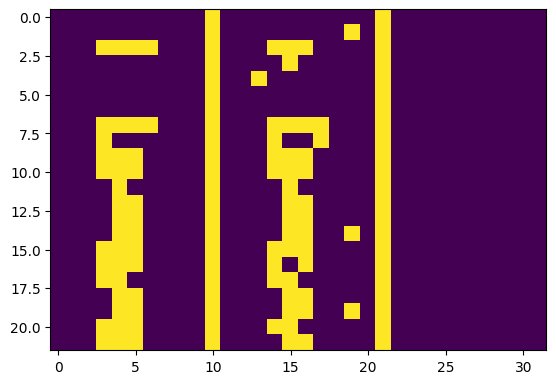

In [133]:
_, y = train_dataset[0]
y_fake = perturb_data(y.unsqueeze(0), 10).squeeze(0)
plt.imshow(render_prediction(y.argmax(0), y_fake.argmax(0), torch.zeros(22, 10)))

Now we'll redefine the training and test loops to just train the discriminator.

In [111]:
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, disc, loss_fn, optimizer_disc, perturb_num):
    disc.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        ##################################################################
        # (1) Update discriminator: minimize -log(D(x)) - log(1 - D(G(z)))
        ##################################################################
        disc.zero_grad()

        ## Train with all-real batch
        # Format batch
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through discriminator
        output = torch.flatten(disc(X, y))
        # Calculate loss on all-real batch
        err_disc_real = loss_fn(output, real_labels)
        # Calculate gradients for discriminator in backward pass
        err_disc_real.backward()

        ## Train with all-fake batch
        # Generate fake image batch with generator
        y_fake = perturb_data(y, perturb_num)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with discriminator
        output = torch.flatten(disc(X, y_fake.detach()))
        # Calculate discriminator's loss on the all-fake batch
        err_disc_fake = loss_fn(output, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()

        ## Update discriminator weights
        # Compute error of discriminator as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update discriminator
        optimizer_disc.step()

        # Output training stats
        if batch % 20 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] D loss: {err_disc.item():.4f}")


def test_loop(split_name, dataloader, disc, loss_fn, tb_writer, epoch, perturb_num):
    disc.eval()

    loss_disc = 0.0
    disc_accuracy = 0.0

    num_batches = len(dataloader)
    with torch.no_grad():        
        for X, y in dataloader:
            batch_size = X.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

            output_real = disc(X, y)
            loss_disc += loss_fn(output_real, real_labels).item()

            y_fake = perturb_data(y, perturb_num)
            output_fake = disc(X, y_fake)
            
            loss_disc += loss_fn(output_fake, fake_labels).item()

            pred_real = (output_real > 0.0)
            pred_fake = (output_fake > 0.0)
            disc_accuracy += pred_real.type(torch.float).mean().item()
            disc_accuracy += (~pred_fake).type(torch.float).mean().item()

    loss_disc /= num_batches
    disc_accuracy /= (2.0 * num_batches)

    print(f"{split_name} error: \n D loss: {loss_disc:>8f}, D accuracy: {(100*disc_accuracy):>0.1f}% \n")

    tb_writer.add_scalar(f"Discriminator loss/{split_name}", loss_disc, epoch)
    tb_writer.add_scalar(f"Discriminator accuracy/{split_name}", disc_accuracy, epoch)


In [135]:
def train(run_name="", disc_cls=TetrisDiscriminator, perturb_num=1, epochs=50, learning_rate=1e-2):
    disc = disc_cls().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer_disc = torch.optim.SGD(disc.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_017")
    log_subdir = os.path.join(log_dir, run_name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    for epoch in range(epochs):
        print(f"Epoch {epoch}\n-------------------------------")
        train_loop(train_dataloader, disc, loss_fn, optimizer_disc, perturb_num)
        test_loop("train", train_dataloader, disc, loss_fn, tb_writer, epoch, perturb_num)
        test_loop("test", test_dataloader, disc, loss_fn, tb_writer, epoch, perturb_num)
        for name, weight in disc.named_parameters():
            tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
            tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)

    tb_writer.close()
    print("Done!")

In [113]:
for i in range(2):
    train(run_name="disc_only_perturbed")

Epoch 0
-------------------------------
[4/1762] D loss: 1.3877
[84/1762] D loss: 1.3890
[164/1762] D loss: 1.3962
[244/1762] D loss: 1.3913
[324/1762] D loss: 1.3757
[404/1762] D loss: 1.3908
[484/1762] D loss: 1.3921
[564/1762] D loss: 1.3837
[644/1762] D loss: 1.3885
[724/1762] D loss: 1.3829
[804/1762] D loss: 1.3851
[884/1762] D loss: 1.3742
[964/1762] D loss: 1.3987
[1044/1762] D loss: 1.3893
[1124/1762] D loss: 1.3944
[1204/1762] D loss: 1.3885
[1284/1762] D loss: 1.3813
[1364/1762] D loss: 1.3849
[1444/1762] D loss: 1.3819
[1524/1762] D loss: 1.3830
[1604/1762] D loss: 1.3863
[1684/1762] D loss: 1.3781
[1762/1762] D loss: 1.3887


KeyboardInterrupt: 

The discriminator fails to learn the difference. This could be because the discriminator architecture isn't good enough, or it could be because the task starts out too difficult. Let's try increasing the number of perturbations to see if this discriminator architecture can succeed on _some_ variant of this task.

In [116]:
for perturb_num in [20]:
    train(run_name=f"perturb_{perturb_num}", perturb_num=perturb_num, epochs=10)

Epoch 0
-------------------------------
[4/1762] D loss: 1.5771
[84/1762] D loss: 1.3010
[164/1762] D loss: 1.2541
[244/1762] D loss: 1.0397
[324/1762] D loss: 0.5639
[404/1762] D loss: 0.5956
[484/1762] D loss: 0.1088
[564/1762] D loss: 0.0952
[644/1762] D loss: 0.0437
[724/1762] D loss: 0.0602
[804/1762] D loss: 0.0304
[884/1762] D loss: 0.0435
[964/1762] D loss: 0.0247
[1044/1762] D loss: 0.0157
[1124/1762] D loss: 0.0219
[1204/1762] D loss: 0.0065
[1284/1762] D loss: 0.0137
[1364/1762] D loss: 0.0072
[1444/1762] D loss: 0.0067
[1524/1762] D loss: 0.0054
[1604/1762] D loss: 0.0088
[1684/1762] D loss: 0.0065
[1762/1762] D loss: 0.0050
train error: 
 D loss: 0.031289, D accuracy: 100.0% 

test error: 
 D loss: 0.030356, D accuracy: 100.0% 

Epoch 1
-------------------------------
[4/1762] D loss: 0.0044
[84/1762] D loss: 0.0134
[164/1762] D loss: 0.0112
[244/1762] D loss: 0.0039
[324/1762] D loss: 0.0068
[404/1762] D loss: 0.0020
[484/1762] D loss: 0.0044
[564/1762] D loss: 0.0028
[64

With 20 perturbations, the model learns easily. Let's try reducing it.

In [117]:
for perturb_num in [10]:
    train(run_name=f"perturb_{perturb_num}", perturb_num=perturb_num, epochs=10)

Epoch 0
-------------------------------
[4/1762] D loss: 1.4080
[84/1762] D loss: 1.3617
[164/1762] D loss: 1.2850
[244/1762] D loss: 1.3432
[324/1762] D loss: 1.2020
[404/1762] D loss: 1.1239
[484/1762] D loss: 0.7668
[564/1762] D loss: 0.7501
[644/1762] D loss: 0.2956
[724/1762] D loss: 1.3914
[804/1762] D loss: 0.0563
[884/1762] D loss: 0.0329
[964/1762] D loss: 0.0500
[1044/1762] D loss: 0.0386
[1124/1762] D loss: 0.0275
[1204/1762] D loss: 0.0175
[1284/1762] D loss: 0.0099
[1364/1762] D loss: 0.0085
[1444/1762] D loss: 0.0079
[1524/1762] D loss: 0.0070
[1604/1762] D loss: 0.0052
[1684/1762] D loss: 0.0042
[1762/1762] D loss: 0.0283
train error: 
 D loss: 0.124173, D accuracy: 100.0% 

test error: 
 D loss: 0.129760, D accuracy: 100.0% 

Epoch 1
-------------------------------
[4/1762] D loss: 0.0078
[84/1762] D loss: 0.0225
[164/1762] D loss: 0.0041
[244/1762] D loss: 0.0026
[324/1762] D loss: 0.0033
[404/1762] D loss: 0.0022
[484/1762] D loss: 0.0102
[564/1762] D loss: 0.0146
[64

With 10 perturbations, the loss is a bit higher, but we still get 100% training and test accuracy within 10 epochs.

In [134]:
for i in range(2):
    for perturb_num in [2, 4, 6, 8, 10]:
        train(run_name=f"perturb_{perturb_num}", perturb_num=perturb_num, epochs=20)

Epoch 0
-------------------------------
[4/1762] D loss: 1.3903
[84/1762] D loss: 1.3958
[164/1762] D loss: 1.3777
[244/1762] D loss: 1.3919
[324/1762] D loss: 1.3784
[404/1762] D loss: 1.3854
[484/1762] D loss: 1.3724
[564/1762] D loss: 1.3850
[644/1762] D loss: 1.3795
[724/1762] D loss: 1.3760
[804/1762] D loss: 1.3632
[884/1762] D loss: 1.3328
[964/1762] D loss: 1.3593
[1044/1762] D loss: 1.3674
[1124/1762] D loss: 1.3672
[1204/1762] D loss: 1.3441
[1284/1762] D loss: 1.3414
[1364/1762] D loss: 1.3580
[1444/1762] D loss: 1.2776
[1524/1762] D loss: 1.3506
[1604/1762] D loss: 1.2070
[1684/1762] D loss: 1.2633
[1762/1762] D loss: 1.2085
train error: 
 D loss: 1.230228, D accuracy: 76.7% 

test error: 
 D loss: 1.238164, D accuracy: 75.8% 

Epoch 1
-------------------------------
[4/1762] D loss: 1.1309
[84/1762] D loss: 1.2966
[164/1762] D loss: 1.0203
[244/1762] D loss: 0.9868
[324/1762] D loss: 0.8806
[404/1762] D loss: 1.1621
[484/1762] D loss: 0.9313
[564/1762] D loss: 1.0454
[644/

The model continues to do well with 10 perturbations, but doesn't always stay at 100%. With 6 and 8 perturbations, the training becomes unstable. With 2 and 4 perturbations, the loss increases on every epoch, which suggests that the learning rate needs to be lowered.

Next, let's fix the number of perturbations to 4 and lower the learning rate to see if we can coax the model to learn effectively in this scenario.

In [137]:
for i in range(2):
    for learning_rate in [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
        run_name = f"perturb_{4}_lr_" + f"{learning_rate:.0e}".replace("-", "m")
        train(run_name=run_name, perturb_num=4, epochs=20, learning_rate=learning_rate)

Epoch 0
-------------------------------
[4/1762] D loss: 1.3941
[84/1762] D loss: 1.4073
[164/1762] D loss: 1.3972
[244/1762] D loss: 1.3715
[324/1762] D loss: 1.3696
[404/1762] D loss: 1.3413
[484/1762] D loss: 1.3662
[564/1762] D loss: 1.3501
[644/1762] D loss: 1.3445
[724/1762] D loss: 1.3190
[804/1762] D loss: 1.2975
[884/1762] D loss: 1.2266
[964/1762] D loss: 1.2772
[1044/1762] D loss: 1.2165
[1124/1762] D loss: 1.1634
[1204/1762] D loss: 1.0208
[1284/1762] D loss: 1.0255
[1364/1762] D loss: 1.2045
[1444/1762] D loss: 0.5860
[1524/1762] D loss: 0.6540
[1604/1762] D loss: 0.3736
[1684/1762] D loss: 0.2220
[1762/1762] D loss: 0.1225
train error: 
 D loss: 0.344409, D accuracy: 95.8% 

test error: 
 D loss: 0.343718, D accuracy: 95.7% 

Epoch 1
-------------------------------
[4/1762] D loss: 0.7793
[84/1762] D loss: 0.0899
[164/1762] D loss: 0.0676
[244/1762] D loss: 0.5823
[324/1762] D loss: 0.2182
[404/1762] D loss: 0.1524
[484/1762] D loss: 0.7471
[564/1762] D loss: 0.2382
[644/

1e-2 is unstable. 1e-3 reaches 99.9% accuracy within 10 epochs and remains stable, but doesn't get to 100% accuracy. 1e-4 shows signs of slow improvement, but needs more than 20 epochs to show real progress. 1e-5 and 1e-6 are too low - they barely show any progress.

Let's repeat with more epochs and more learning rates, but discard those above 1e-3 or below 1e-5.

In [139]:
#for learning_rate in [1e-3, 3e-3, 1e-4, 3e-4, 1e-5]:
for learning_rate in [3e-4, 1e-4, 3e-5, 1e-5]:
    run_name = f"perturb_{4}_lr_" + f"{learning_rate:.0e}".replace("-", "m")
    train(run_name=run_name, perturb_num=4, epochs=50, learning_rate=learning_rate)

Epoch 0
-------------------------------
[4/1762] D loss: 1.3675
[84/1762] D loss: 1.3865
[164/1762] D loss: 1.3990
[244/1762] D loss: 1.3828
[324/1762] D loss: 1.3999
[404/1762] D loss: 1.4003
[484/1762] D loss: 1.3883
[564/1762] D loss: 1.3942
[644/1762] D loss: 1.3913
[724/1762] D loss: 1.3857
[804/1762] D loss: 1.3875
[884/1762] D loss: 1.3704
[964/1762] D loss: 1.3721
[1044/1762] D loss: 1.3757
[1124/1762] D loss: 1.3831
[1204/1762] D loss: 1.3693
[1284/1762] D loss: 1.3792
[1364/1762] D loss: 1.3798
[1444/1762] D loss: 1.3803
[1524/1762] D loss: 1.3943
[1604/1762] D loss: 1.3855
[1684/1762] D loss: 1.3945
[1762/1762] D loss: 1.3701
train error: 
 D loss: 1.385147, D accuracy: 51.7% 

test error: 
 D loss: 1.385340, D accuracy: 52.8% 

Epoch 1
-------------------------------
[4/1762] D loss: 1.3746
[84/1762] D loss: 1.3766
[164/1762] D loss: 1.3689
[244/1762] D loss: 1.3883
[324/1762] D loss: 1.3832
[404/1762] D loss: 1.3798
[484/1762] D loss: 1.3942
[564/1762] D loss: 1.3729
[644/

Reducing the learning rate from 1e-3 to 3e-4 or lower makes the training longer and stops the loss from eventually increasing. With 3e-4, the final accuracy seems slightly better than with 1e-3, but still not 100%.

Now let's try the same set of learning rates while only perturbing 2 cells.

In [140]:
for learning_rate in [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]:
    run_name = f"perturb_{2}_lr_" + f"{learning_rate:.0e}".replace("-", "m")
    train(run_name=run_name, perturb_num=2, epochs=50, learning_rate=learning_rate)

Epoch 0
-------------------------------
[4/1762] D loss: 1.3966
[84/1762] D loss: 1.3859
[164/1762] D loss: 1.3986
[244/1762] D loss: 1.3897
[324/1762] D loss: 1.3915
[404/1762] D loss: 1.3832
[484/1762] D loss: 1.3926
[564/1762] D loss: 1.3858
[644/1762] D loss: 1.3880
[724/1762] D loss: 1.3840
[804/1762] D loss: 1.3786
[884/1762] D loss: 1.3793
[964/1762] D loss: 1.3858
[1044/1762] D loss: 1.3908
[1124/1762] D loss: 1.3995
[1204/1762] D loss: 1.3784
[1284/1762] D loss: 1.3680
[1364/1762] D loss: 1.3816
[1444/1762] D loss: 1.3830
[1524/1762] D loss: 1.3968
[1604/1762] D loss: 1.3759
[1684/1762] D loss: 1.3921
[1762/1762] D loss: 1.3668
train error: 
 D loss: 1.384105, D accuracy: 50.5% 

test error: 
 D loss: 1.384721, D accuracy: 50.3% 

Epoch 1
-------------------------------
[4/1762] D loss: 1.3749
[84/1762] D loss: 1.3875
[164/1762] D loss: 1.3831
[244/1762] D loss: 1.3731
[324/1762] D loss: 1.3900
[404/1762] D loss: 1.3882
[484/1762] D loss: 1.3881
[564/1762] D loss: 1.3793
[644/

As expected, when there are fewer perturbations, the model learns more slowly with a given learning rate. 1e-3 now becomes unstable. 3e-4 actually learns a bit faster but starts becoming a bit unstable towards the end. 1e-4 shows promise but doesn't significantly converge within 50 epochs. 3e-5 is much too slow.

So, we have demonstrated that the discriminator architecture can learn to distinguish even small bits of random noise from the real frames, but the original learning rate of 1e-2 may be too high for the GAN training. However, the discriminator cannot achieve 100% training accuracy on the perturbation task, so there may be improvements that can be made to the architecture.

The first thing we should try is reducing the learning rate on the GAN training and see if that improves the situation.

Later, we can experiment more with the perturbation task and see if we can find an architecture that works better for it, and see how that architecture fares as a discriminator in the GAN training.

Let's reinstate the original training functions, with some additional parameters.

In [141]:
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc):
    gen.train()
    disc.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        ##################################################################
        # (1) Update discriminator: minimize -log(D(x)) - log(1 - D(G(z)))
        ##################################################################
        disc.zero_grad()

        ## Train with all-real batch
        # Format batch
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through discriminator
        output = torch.flatten(disc(X, y))
        # Calculate loss on all-real batch
        err_disc_real = loss_fn(output, real_labels)
        # Calculate gradients for discriminator in backward pass
        err_disc_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.rand(batch_size, 4, device=device)
        # Generate fake image batch with generator
        y_fake = gen(X, z)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with discriminator
        output = torch.flatten(disc(X, y_fake.detach()))
        # Calculate discriminator's loss on the all-fake batch
        err_disc_fake = loss_fn(output, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()

        ## Update discriminator weights
        # Compute error of discriminator as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update discriminator
        optimizer_disc.step()

        ##############################################
        # (2) Update generator: minimize -log(D(G(z)))
        ##############################################
        gen.zero_grad()
        # Since we just updated the discriminator, perform another forward pass of the all-fake batch through it
        output = torch.flatten(disc(X, y_fake))
        # Calculate the generator's loss based on this output
        # We use real labels because the generator wants to fool the discriminator
        err_gen = loss_fn(output, real_labels)
        # Calculate gradients for generator
        err_gen.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if batch % 20 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] D loss: {err_disc.item():.4f}, G loss: {err_gen.item():.4f}")


def test_loop(split_name, dataloader, gen, disc, loss_fn, tb_writer, epoch, examples):
    gen.eval()
    disc.eval()

    loss_disc = 0.0
    loss_gen = 0.0
    disc_accuracy = 0.0
    cell_accuracy = 0.0
    board_accuracy = 0.0
    spawn_recall = 0.0
    num_spawns = 0.0
    spawn_precision = 0.0
    num_predicted_spawns = 0.0

    num_batches = len(dataloader)
    with torch.no_grad():        
        for X, y in dataloader:
            batch_size = X.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

            output_real = disc(X, y)
            loss_disc += loss_fn(output_real, real_labels).item()

            z = torch.rand(batch_size, 4, device=device)
            y_fake = gen(X, z)
            output_fake = disc(X, y_fake)
            
            loss_disc += loss_fn(output_fake, fake_labels).item()
            loss_gen += loss_fn(output_fake, real_labels).item()

            pred_real = (output_real > 0.0)
            pred_fake = (output_fake > 0.0)
            disc_accuracy += pred_real.type(torch.float).mean().item()
            disc_accuracy += (~pred_fake).type(torch.float).mean().item()

            classes_X = torch.argmax(X, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            cell_accuracy += (classes_y_fake == classes_y).type(torch.float).mean().item()
            board_accuracy += (classes_y_fake == classes_y).all(-1).all(-1).type(torch.float).mean().item()

            actual_spawns = (classes_X[:, 0, :] == 0).all(-1) & (classes_y[:, 0, :] == 1).any(-1)
            predicted_spawns = (classes_y_fake[:, 0, :] == 1).any(-1)
            num_true_positives = (actual_spawns & predicted_spawns).type(torch.float).sum().item()
            spawn_recall += num_true_positives
            num_spawns += actual_spawns.type(torch.float).sum().item()
            spawn_precision += num_true_positives
            num_predicted_spawns += predicted_spawns.type(torch.float).sum().item()

    loss_disc /= num_batches
    loss_gen /= num_batches
    cell_accuracy /= num_batches
    board_accuracy /= num_batches
    spawn_recall /= num_spawns
    spawn_precision = np.nan if (num_predicted_spawns == 0.0) else (spawn_precision / num_predicted_spawns)
    disc_accuracy /= (2.0 * num_batches)

    print(f"{split_name} error: \n D loss: {loss_disc:>8f}, G loss: {loss_gen:>8f}, D accuracy: {(100*disc_accuracy):>0.1f}%, cell accuracy: {(100*cell_accuracy):>0.1f}%, board accuracy: {(100*board_accuracy):>0.1f}% \n")

    tb_writer.add_scalar(f"Discriminator loss/{split_name}", loss_disc, epoch)
    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Discriminator accuracy/{split_name}", disc_accuracy, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy, epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy, epoch)
    tb_writer.add_scalar(f"Spawn recall/{split_name}", spawn_recall, epoch)

    with torch.no_grad():
        for i, (X, y) in enumerate(examples):
            X, y = X.unsqueeze(0), y.unsqueeze(0)
            z = torch.rand(1, 4, device=device)
            y_fake = gen(X, z)
            X, y, y_fake = X.squeeze(0), y.squeeze(0), y_fake.squeeze(0)
            X, y, y_fake = X.argmax(0), y.argmax(0), y_fake.argmax(0)
            img = render_prediction(X, y_fake, y)
            tb_writer.add_image(f"Predictions/{split_name}/{i}", img, epoch, dataformats="HW")


In [142]:
def train(run_name="", disc_cls=TetrisDiscriminator, learning_rate=1e-2, epochs=50):
    gen = TetrisModel().to(device)
    disc = disc_cls().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer_gen = torch.optim.SGD(gen.parameters(), lr=learning_rate)
    optimizer_disc = torch.optim.SGD(disc.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_017")
    log_subdir = os.path.join(log_dir, run_name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    train_examples = find_interesting_examples(train_dataset)
    test_examples = find_interesting_examples(test_dataset)

    for epoch in range(epochs):
        print(f"Epoch {epoch}\n-------------------------------")
        train_loop(train_dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc)
        test_loop("train", train_dataloader, gen, disc, loss_fn, tb_writer, epoch, train_examples)
        test_loop("test", test_dataloader, gen, disc, loss_fn, tb_writer, epoch, test_examples)
        for name, weight in gen.named_parameters():
            tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
            tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
        for name, weight in disc.named_parameters():
            tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
            tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)

    tb_writer.close()
    print("Done!")

In [144]:
for i in range(2):
    #for learning_rate in [1e-2, 3e-3, 1e-3, 3e-3, 1e-4]:
    for learning_rate in [3e-4]:
        run_name=f"lr_{learning_rate:.0e}".replace("-", "m")
        train(run_name=run_name, learning_rate=learning_rate, epochs=100)

Epoch 0
-------------------------------
[4/1762] D loss: 1.3827, G loss: 0.5689
[84/1762] D loss: 1.3852, G loss: 0.5811
[164/1762] D loss: 1.3851, G loss: 0.5866
[244/1762] D loss: 1.3726, G loss: 0.5936
[324/1762] D loss: 1.3878, G loss: 0.5953
[404/1762] D loss: 1.3623, G loss: 0.5950
[484/1762] D loss: 1.3455, G loss: 0.6294
[564/1762] D loss: 1.3457, G loss: 0.6200
[644/1762] D loss: 1.3526, G loss: 0.6451
[724/1762] D loss: 1.3516, G loss: 0.6097
[804/1762] D loss: 1.3483, G loss: 0.6067
[884/1762] D loss: 1.3292, G loss: 0.6407
[964/1762] D loss: 1.3156, G loss: 0.6322
[1044/1762] D loss: 1.3471, G loss: 0.6470
[1124/1762] D loss: 1.2974, G loss: 0.6559
[1204/1762] D loss: 1.3176, G loss: 0.6646
[1284/1762] D loss: 1.2836, G loss: 0.6769
[1364/1762] D loss: 1.2902, G loss: 0.6682
[1444/1762] D loss: 1.2838, G loss: 0.6974
[1524/1762] D loss: 1.2555, G loss: 0.6862
[1604/1762] D loss: 1.2554, G loss: 0.7219
[1684/1762] D loss: 1.2838, G loss: 0.6889
[1762/1762] D loss: 1.2894, G 

Looks like varying the learning rate isn't enough to solve the board accuracy or instability issues. All the learning rates attempted here show instability and none of them result in a training accuracy consistently above 90%. Reducing the learning rate to 1e-4 slows down the training and makes the final board accuracy siginificantly worse (around 80% instead of around 90%).

# Conclusion

In this experiment, we were not able to improve the board accuracy of the generator. However, we confirmed that the discriminator architecture is reasonable for the task, since the discriminator can be independently trained to distinguish `y` from `y_fake` when `y_fake` is `y` but with a small number of cells randomly flipped.

We note that even for this "perturbation" task, we didn't find any model architectures which trained to 100% accuracy when the number of flips was small. This could be for one of two reasons:
* Maybe the task is impossible to get 100% accuracy in, because in some cases the cell flips could transform one block spawn type into another. It's unclear how often this would happen.
* Maybe the model is not capable of learning to 100% with the given architecture and/or hyperparameters, so these should be changed.

An alternative task would be to fix a version of the generator and just train the discriminator to score highly against this fixed generator. Let's call this the "fixed generator" task.

The next step is to experiment with training a discriminator on either the perturbation task or the fixed generator task, and find a discriminator architecture and hyperparameters that give significantly better performance. There are some "GAN hacks" we could try here: https://github.com/soumith/ganhacks.